In [8]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import cartopy.crs as ccrs
import numpy as np
import os
import sys
from sklearn.metrics import mean_squared_error
sys.path.append("/global/homes/z/zhangtao/my_utils/src/")
from cmocean import cm as cmo
from PIL import Image
import glob
from cartopy.io.img_tiles import Stamen
import cartopy.feature as cfeature
%matplotlib inline

In [3]:
def make_gif(path,var,nstep=200,lt=0):
    frames = []
    for day in range(1,32):
        date = "201901"+f'{day:02d}'
        for hour in range(24):
            hour = f'{hour:02d}'
            
            image = path+"/"+date+"-"+hour+".png"
            frames.append(Image.open(image))
    frame_one = frames[0]
    frame_one.save(path+"/wind.gif", format="GIF", append_images=frames,save_all=True, duration=100, loop=0)

In [4]:
sites = ['KIAG','KDSV','KPEO','KITH','KELM','KELZ',
        'KFZY','KRME','KGTB','KMSS','KPBG','KGFL',
        'KALB','KMGJ','KFRG','KISP','KFOK','KBID']

sites_sel = ['KFOK','KFRG','KISP','KIAG','KGTB','KRME','KDSV','KELZ','KPEO',
        'KITH','KALB','KELM','KGFL','KMGJ']

In [5]:
site_info = pd.read_csv("/global/homes/z/zhangtao/wind_forecast/data/site_info",sep='\s+')
site_info['lon'] = 360 - site_info['lon']

sites_dict = {}
sites = site_info.loc[:,'site'].values
sites_lat = site_info.loc[:,'lat'].values
sites_lon = site_info.loc[:,'lon'].values

for i,site in enumerate(sites):
    sites_dict[site] = [sites_lon[i],sites_lat[i]]

site_info

,site,lat,lon
0,KFOK,40.85,287.37
1,KFRG,40.73,286.59
2,KISP,40.80,286.90
3,KDSV,42.57,282.29
4,KELM,42.17,283.10
5,KELZ,42.11,282.02
6,KITH,42.48,283.53
7,KMSV,41.70,285.20
8,KPEO,42.64,282.95
9,KRME,43.23,284.60


# open grib2 

In [5]:
lt = 1
date_pre = "201901"
hrrr_path = "/global/cscratch1/sd/zhangtao/wind_forecast/hrrr/hrrr_Herbie/hrrr/"
#fid = xr.open_dataset(hrrr_path+"20190101/hrrr.t06z.wrfsfcf"+f'{lt:02d}'+".grib2",engine='cfgrib',
#                     backend_kwargs={'filter_by_keys': {'typeOfLevel': 'surface','stepType': 'instant'}})

In [1]:
gusts_data = np.zeros([24*31,len(sites)])

for d in range(20,32):
    date = date_pre + f'{d:02d}'
    print(date)
    for h in range(24):
        fid = xr.open_dataset(hrrr_path+date+"/hrrr.t"+f'{h:02d}'+"z.wrfsfcf"+f'{lt:02d}'+".grib2",engine='cfgrib',
                     backend_kwargs={'filter_by_keys': {'typeOfLevel': 'surface','stepType': 'instant'}})

        for j,site in enumerate(sites):
            _lat = site_info[site_info['site']==site]['lat'].values
            _lon = site_info[site_info['site']==site]['lon'].values

            gust = fid['gust']

            abslat = np.abs(gust.latitude - _lat)
            abslon = np.abs(gust.longitude - _lon)
            c = np.maximum(abslon, abslat)

            ([xloc], [yloc]) = np.where(c == np.min(c))

            _gust = gust.sel(x=yloc,y=xloc)

            gusts_data[(d-1)*24+h,j] = _gust
        

NameError: name 'np' is not defined

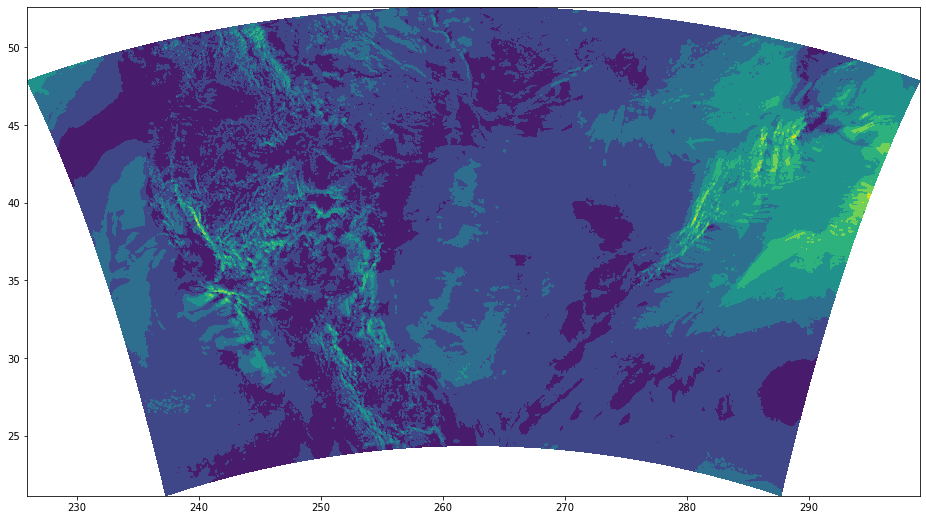

In [53]:
plt.figure(figsize=(16,9))
plt.contourf(lon,lat,gust)

# open netcdf

In [ ]:
lt = 12
data_path = "/global/cscratch1/sd/zhangtao/wind_forecast/hrrr/hrrr_Herbie/hrrr/lt"+str(lt)
date_pre = "201901"

gusts_data = np.zeros([24*31,len(sites)])
for d in range(1,32):
    date = date_pre + f'{d:02d}'
    print(date)
    for h in range(24):
        nc_file = data_path+"/"+date+"/hrrr.t"+f'{h:02d}'+"z.wrfsfcf"+f'{lt:02d}'+".nc"
        fid = xr.open_dataset(nc_file)
        gust = fid['GUST_P0_L1_GLC0']
        lat = gust.gridlat_0
        lon = gust.gridlon_0 + 360

        for j,site in enumerate(sites):
            _lat = site_info[site_info['site']==site]['lat'].values
            _lon = site_info[site_info['site']==site]['lon'].values
            

            abslat = np.abs(lat - _lat)
            abslon = np.abs(lon - _lon)
            c = np.maximum(abslon, abslat)

            ([xloc], [yloc]) = np.where(c == np.min(c))

            _gust = gust.sel(xgrid_0=yloc,ygrid_0=xloc)
            
            #print([xloc])
            #print(_lat,_lon)
            #print(_gust.data)
            #print(xloc)
            #print(_gust.data)
            
            gusts_data[(d-1)*24+h,j] = _gust

20190101
20190102
20190103
20190104
20190105
20190106
20190107
20190108
20190109
20190110
20190111
20190112
20190113
20190114
20190115
20190116
20190117
20190118
20190119
20190120
20190121
20190122
20190123
20190124
20190125


In [9]:
np.save("gusts_lt1.npy",gusts_data)

In [10]:
hrrr = np.load("gusts_lt1.npy")
hrrr = pd.DataFrame(hrrr, columns=sites)

In [11]:

def load_wind_data_xy(year, mons):
    '''
    output: shape by time x location_x x location_y x vars
    '''
    data_path="/global/homes/z/zhangtao/wind_forecast/wuli_test/data/"
    ft_all = ['Time','Temperature','Dew Point','Wind Direction','Wind Speed',
          'Pressure','CA1','CA2','CA3','CA4','CA5','CA6','CH1','CH2','CH3',
          'CH4','CH5','CH6','Prect']
    fts = ['Temperature','Dew Point','Wind Direction','Wind Speed','Pressure','Prect']
    
    data_allsite = []
    for site in sites:
        data_1site = pd.DataFrame()
        for mon in mons:
            data_file = data_path+str(year)+f'{mon:02d}'+site+"_data.txt"

            data = pd.read_csv(data_file, sep='\s+', header=None)
            data.columns = ft_all
            data = data[fts]

            #remove missing
            for ft in ['Temperature','Dew Point','Wind Direction','Wind Speed','Prect']:
                data.loc[:,ft].replace(999,np.nan, inplace=True)
            data.loc[:,'Pressure'].replace(99999,np.nan, inplace=True)
            data.loc[:,'Prect'].replace(99999,np.nan, inplace=True)
            #data.loc[:,'Prect'].replace(99999,method='bfill', inplace=True)
            data.fillna(method="ffill", inplace=True)
            data.fillna(method="bfill", inplace=True)
            
            if data.isnull().any().sum():
                print(f'{site=},{mon}')
            
            data_1site = pd.concat([data_1site, data]).reset_index(drop=True)
            
        data_allsite.append(data_1site)
        #print(data_1site.shape)

    data_allsite = np.stack(data_allsite)
    data_allsite = np.swapaxes(data_allsite,0,1)
    data_allsite = data_allsite.reshape(data_allsite.shape[0],3,6,data_allsite.shape[-1])[:,:,:,3:4]
    print(data_allsite.shape)
    return data_allsite

In [12]:
year = 2019
mons  = [1]
obs_data = load_wind_data_xy(year, mons).reshape(-1,18)
obs_data = pd.DataFrame(obs_data, columns=sites)
obs_data

(744, 3, 6, 1)


,KIAG,KDSV,KPEO,KITH,KELM,KELZ,KFZY,KRME,KGTB,KMSS,KPBG,KGFL,KALB,KMGJ,KFRG,KISP,KFOK,KBID
0,7.0,13.0,9.0,14.0,6.0,8.0,7.0,9.0,17.0,6.0,8.0,0.0,8.0,4.0,9.0,11.0,9.0,11.0
1,9.0,10.0,11.0,13.0,0.0,8.0,8.0,12.0,18.0,6.0,11.0,0.0,11.0,3.0,15.0,14.0,9.0,14.0
2,11.0,12.0,11.0,21.0,0.0,14.0,7.0,10.0,20.0,7.0,14.0,0.0,10.0,5.0,20.0,19.0,13.0,15.0
3,0.0,13.0,16.0,18.0,7.0,11.0,9.0,7.0,20.0,10.0,12.0,0.0,12.0,6.0,14.0,16.0,13.0,13.0
4,11.0,11.0,15.0,20.0,0.0,22.0,10.0,11.0,18.0,8.0,14.0,3.0,13.0,5.0,13.0,15.0,17.0,21.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
739,21.0,7.0,11.0,11.0,12.0,11.0,15.0,15.0,7.0,14.0,8.0,11.0,10.0,10.0,9.0,9.0,11.0,13.0
740,23.0,7.0,16.0,14.0,11.0,15.0,17.0,15.0,6.0,12.0,6.0,10.0,9.0,12.0,10.0,12.0,11.0,12.0
741,20.0,5.0,17.0,12.0,9.0,10.0,18.0,16.0,9.0,13.0,6.0,10.0,11.0,10.0,11.0,12.0,13.0,17.0
742,19.0,7.0,8.0,8.0,12.0,11.0,18.0,14.0,11.0,9.0,4.0,8.0,9.0,12.0,11.0,10.0,9.0,15.0


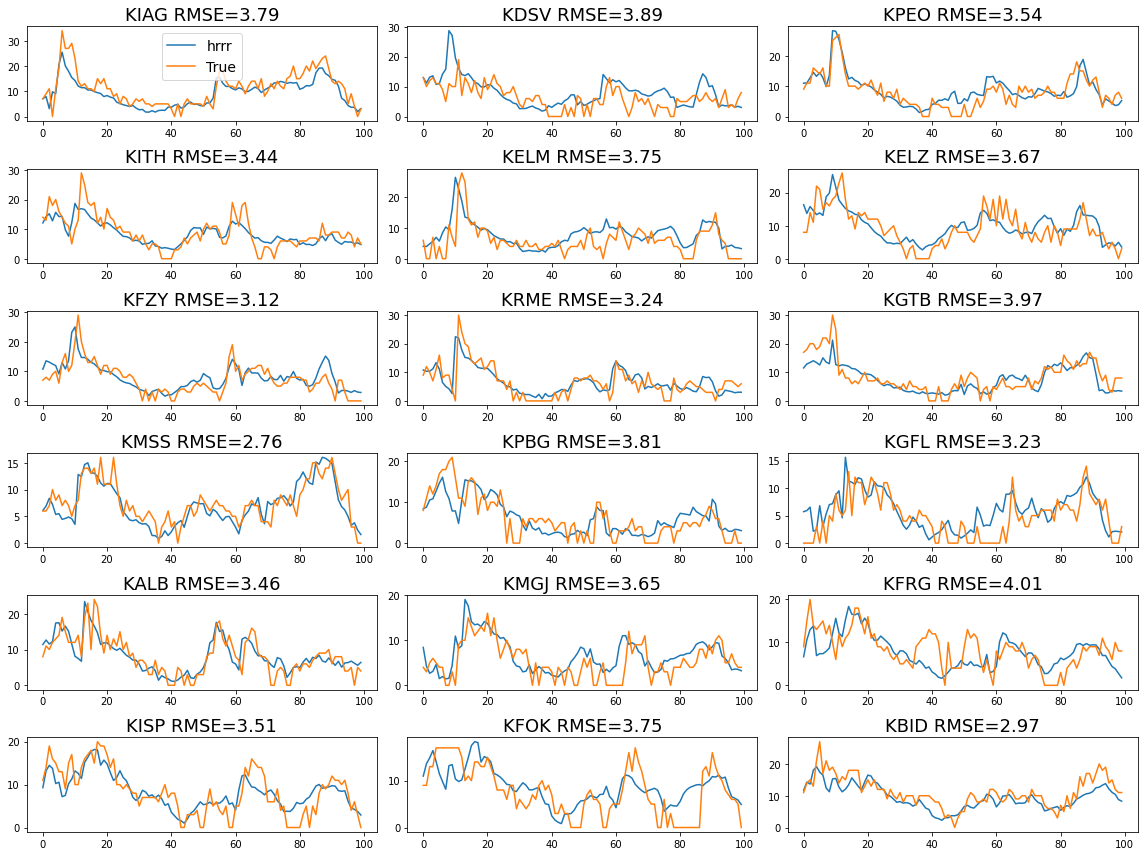

In [13]:
fh = 18
fig, axes = plt.subplots(6,3,figsize=(16,12))
for i, site in enumerate(sites):
    rms = mean_squared_error(obs_data[site],hrrr[site]) ** 0.5
    axes[i//3][i%3].plot(hrrr[site][:100],label="hrrr")
    axes[i//3][i%3].plot(obs_data[site][:100],label="True")
    axes[i//3][i%3].set_title(site+f' RMSE={rms:.2f}',fontsize=fh)
    
axes[0][0].legend(fontsize=fh-4)
plt.tight_layout()

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
739    0.0
740    0.0
741    0.0
742    0.0
743    0.0
Length: 744, dtype: float64

In [ ]:
%%capture

colorbar_range = np.arange(0,35.1,1)

import cartopy.feature as cfeature

for day in range(31,32):
    date = "201901"+f'{day:02d}'
    for hour in range(24):
        hour = f'{hour:02d}'
    
        path="/global/cscratch1/sd/zhangtao/wind_forecast/hrrr/hrrr_Herbie/hrrr/lt1/"+date+"/"
        fid = xr.open_dataset(path+'hrrr.t'+hour+'z.wrfsfcf01.nc')
        var = fid['GUST_P0_L1_GLC0']
        lat = fid.gridlat_0
        lon = fid.gridlon_0 + 180

        lat_rgns = [40, 45]
        lon_rgns = [280, 290]

        fig, ax = plt.subplots(1,1,figsize=(14,9.5),subplot_kw={'projection':  ccrs.PlateCarree(180)})

        ax.set_extent([lon_rgns[0],lon_rgns[1]+1,lat_rgns[0],lat_rgns[1]+1], ccrs.PlateCarree())
        ax.coastlines() 
        ax.add_feature(cfeature.RIVERS)
        ax.add_feature(cfeature.LAKES)
        states_provinces = cfeature.NaturalEarthFeature(
            category='cultural',
            name='admin_1_states_provinces_lines',
            scale='50m',
            facecolor='none')
        ax.add_feature(states_provinces,edgecolor='gray')
        #ax.add_feature(cfeature.LAND)
        #ax.add_feature(cfeature.OCEAN)

        for site in sites_sel:
            ax.plot(sites_dict[site][0], sites_dict[site][1], marker='.', 
                    color='red', markersize=12, alpha=0.7, transform=ccrs.Geodetic())
            ax.text(sites_dict[site][0], sites_dict[site][1],site,
                    transform=ccrs.Geodetic(), fontsize=8,
                   verticalalignment='center', horizontalalignment='right')
            ax.set_title(date+"-"+hour)
        mm = ax.contourf(lon,lat,var,colorbar_range,cmap=cmo.rain)
        cbar = fig.colorbar(mm, fraction=0.018, ax=ax)

        plt.savefig('diag/'+date+"-"+hour+".png")

In [ ]:
make_gif('diag/','a',1,1)

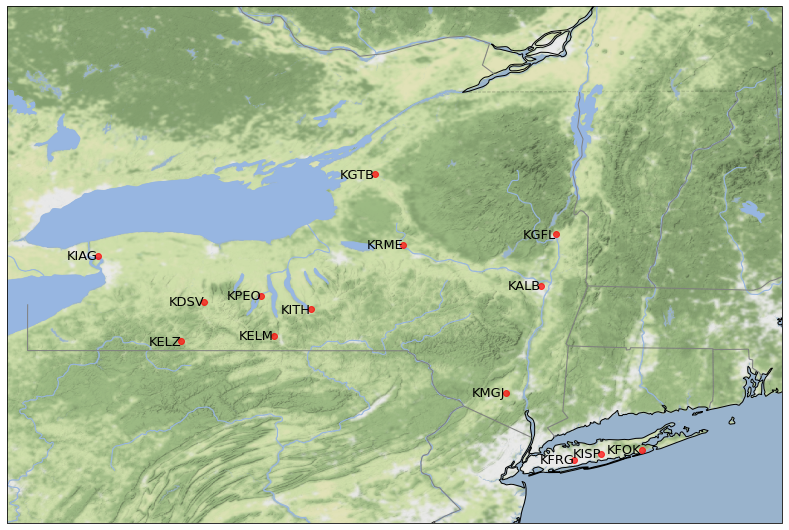

In [20]:
date = '20190101'
hour = '02'
path="/global/cscratch1/sd/zhangtao/wind_forecast/hrrr/hrrr_Herbie/hrrr/lt1/"+date+"/"
fid = xr.open_dataset(path+'hrrr.t'+hour+'z.wrfsfcf01.nc')
var = fid['GUST_P0_L1_GLC0']
lat = fid.gridlat_0
lon = fid.gridlon_0 + 180

lat_rgns = [40, 45]
lon_rgns = [280, 288]

fig, ax = plt.subplots(1,1,figsize=(14,9.5),subplot_kw={'projection':  ccrs.PlateCarree(180)})

ax.set_extent([lon_rgns[0],lon_rgns[1]+1,lat_rgns[0],lat_rgns[1]+1], ccrs.PlateCarree())
ax.coastlines() 
ax.add_feature(cfeature.RIVERS)
ax.add_feature(cfeature.LAKES)
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')
ax.add_feature(states_provinces,edgecolor='gray')

stamen_terrain = Stamen('terrain-background')
ax.add_image(stamen_terrain, 8)


#ax.add_feature(cfeature.LAND)
#ax.add_feature(cfeature.OCEAN)

for site in sites_sel:
    ax.plot(sites_dict[site][0], sites_dict[site][1], marker='.', 
            color='red', markersize=12, alpha=0.7, transform=ccrs.Geodetic())
    ax.text(sites_dict[site][0], sites_dict[site][1],site,
            transform=ccrs.Geodetic(), fontsize=13,
           verticalalignment='center', horizontalalignment='right')
    #ax.set_title(date+"-"+hour)
    
plt.savefig("location.pdf")

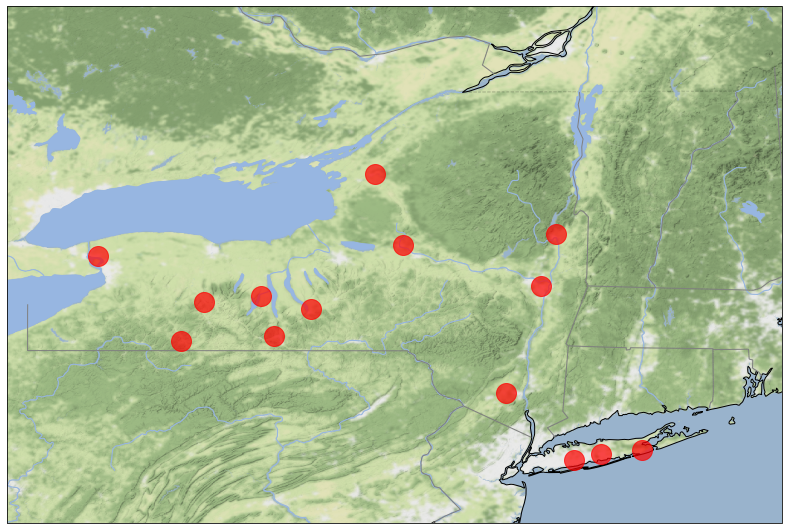

In [14]:
date = '20190101'
hour = '02'
path="/global/cscratch1/sd/zhangtao/wind_forecast/hrrr/hrrr_Herbie/hrrr/lt1/"+date+"/"
fid = xr.open_dataset(path+'hrrr.t'+hour+'z.wrfsfcf01.nc')
var = fid['GUST_P0_L1_GLC0']
lat = fid.gridlat_0
lon = fid.gridlon_0 + 180

lat_rgns = [40, 45]
lon_rgns = [280, 288]

fig, ax = plt.subplots(1,1,figsize=(14,9.5),subplot_kw={'projection':  ccrs.PlateCarree(180)})

ax.set_extent([lon_rgns[0],lon_rgns[1]+1,lat_rgns[0],lat_rgns[1]+1], ccrs.PlateCarree())
ax.coastlines() 
ax.add_feature(cfeature.RIVERS)
ax.add_feature(cfeature.LAKES)
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')
ax.add_feature(states_provinces,edgecolor='gray')

stamen_terrain = Stamen('terrain-background')
ax.add_image(stamen_terrain, 8)


#ax.add_feature(cfeature.LAND)
#ax.add_feature(cfeature.OCEAN)

for site in sites_sel:
    ax.plot(sites_dict[site][0], sites_dict[site][1], marker='.', 
            color='red', markersize=40, alpha=0.7, transform=ccrs.Geodetic())

    
plt.savefig("location.pdf")

In [6]:
fig, axes = plt.subplots(1,1,figsize=(16,9))
link_wind = linkage(train_data.reshape(-1,15,6)[:,:,3].T, 'ward')
aa = dendrogram(link_wind,labels=sites, ax=axes)
axes.tick_params(axis='x', labelsize=16)
axes.tick_params(axis='y', labelsize=16)
axes.set_xlabel("Sites",fontsize=16)
axes.set_ylabel("Euclidean distance",fontsize=16)

/global/common/software/m2136/conda/envs/tensorflow/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


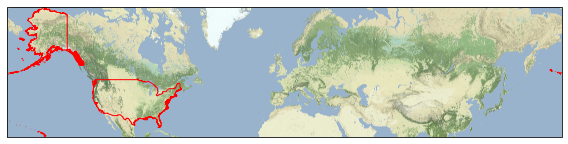

In [18]:
from cartopy.io import shapereader
import cartopy.io.img_tiles as cimgt
import cartopy.crs as ccrs
import geopandas
import matplotlib.pyplot as plt


resolution = '10m'
category = 'cultural'
name = 'admin_0_countries'

shpfilename = shapereader.natural_earth(resolution, category, name)

df = geopandas.read_file(shpfilename)

poly = [df.loc[df['ADMIN'] == 'United States of America']['geometry'].values[0]]

stamen_terrain = cimgt.Stamen('terrain-background')

fig = plt.figure(figsize=(8,6))

ax = fig.add_subplot(1, 1, 1, projection=stamen_terrain.crs)
ax.add_geometries(poly, crs=ccrs.PlateCarree(), facecolor='none', edgecolor='r')
exts = [poly[0].bounds[0], poly[0].bounds[2], poly[0].bounds[1], poly[0].bounds[3]]
ax.set_extent(exts, crs=ccrs.Geodetic())

ax.add_image(stamen_terrain, 8)
fig.tight_layout()

In [19]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from cartopy.io.img_tiles import Stamen
import cartopy.io.img_tiles as cimgt
from matplotlib.transforms import offset_copy

Text(19.06, 47.47, 'Budapest')

/global/common/software/m2136/conda/envs/tensorflow/lib/python3.10/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/global/common/software/m2136/conda/envs/tensorflow/lib/python3.10/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_rivers_lake_centerlines.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


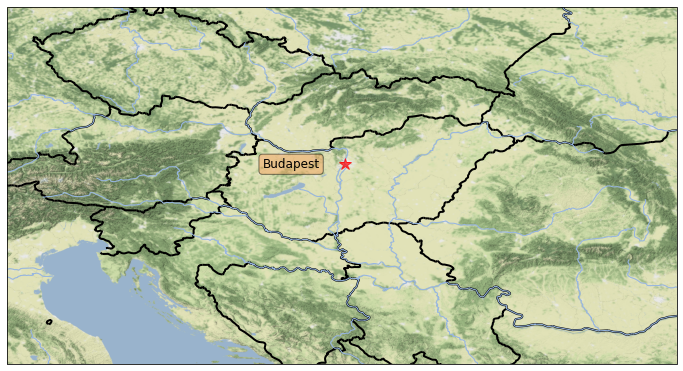

In [20]:
# getting terrain data
stamen_terrain = Stamen('terrain-background')

# declaring figure and size
fig = plt.figure(figsize=[12,10])

# decalring projection ( you can change projections accordign to your need)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# now we are giving corners of our map
ax.set_extent([11.5, 26.5, 43, 51])
# ax.set_extent([16, 23, 45.5, 49])# , crs=ccrs.PlateCarree())

# this is overlaying terrain (8 = zoom level of terrain)
ax.add_image(stamen_terrain, 8)

#overlaying borders and rivers
ax.add_feature(cfeature.BORDERS,linewidth=2)#, linestyle=':')
ax.add_feature(cfeature.RIVERS)

# this will mark the point where you need 
plt.plot(19.06, 47.47, marker='*', color='red', markersize=12,
             alpha=0.7, transform=ccrs.Geodetic())

geodetic_transform = ccrs.Geodetic()._as_mpl_transform(ax)
text_transform = offset_copy(geodetic_transform, units='dots', x=-25)

# Add text 25 pixels to the left of the volcano.
plt.text(19.06, 47.47, u'Budapest',
         verticalalignment='center', horizontalalignment='right',
         transform=text_transform,fontsize=12,
         bbox=dict(facecolor='sandybrown', alpha=0.5, boxstyle='round'))



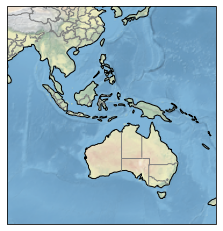

In [31]:
from matplotlib.offsetbox import AnchoredText

ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([80, 170, -45, 30])

# Put a background image on for nice sea rendering.
ax.stock_img()

# Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')

SOURCE = 'Natural Earth'
LICENSE = 'public domain'

ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(states_provinces, edgecolor='gray')

# Add a text annotation for the license information to the
# the bottom right corner.
#text = AnchoredText(r'$\mathcircled{{c}}$ {}; license: {}'
#                    ''.format(SOURCE, LICENSE),
#                    loc=4, prop={'size': 12}, frameon=True)
#ax.add_artist(text)